In [ ]:
## GJK Distance Algorithm Implementation By ME
import numpy as np

EPSILPON = 0.001

def gjk_distance(shape1, shape2, simplex, distPrev = None, alg = True):#alg = True means it uses DS, False uses BP
    """Calculate the distance between two convex shapes using the GJK algorithm."""
    print('in')
    vj = shape2.center - shape1.center
    new_simplex, v, distB, alg = distance_subalgorithm(simplex, vj, alg)
    support = shape1.support(v) - shape2.support(-v)
    
    if gk(v, support) <= EPSILPON:
        return distB, v, new_simplex, True
    
    print(distB, distPrev)
    if (not distPrev) or distB < distPrev:
        new_simplex.append(support)
        return gjk_distance(shape1, shape2, new_simplex, distB)
    
    if not alg: #backup procedure used and tolerance not satisfied
        return distB, v, new_simplex, alg #backup procedure used and tolerance not satisfied
    
    return gjk_distance(shape1, shape2, simplex, distPrev, False)
    

def distance_subalgorithm(simplex, vj, ds = True):
    """Sub-algorithm to compute the distance based on the current simplex."""
    if not ds:
        print('BP')
        return backup_procedure(simplex)
    all_simplexs = generate_all_simplexs_with_support(simplex[:-1], simplex[-1])
    for curr_simplex in all_simplexs:
        k = curr_simplex[0]
        del_simplex = del_y(curr_simplex, k)
        del_simplex_val = 0
        inside = True
        for i in del_simplex: #check if all del_simplex values are positive
            if i<0:
                inside = False
                break
            del_simplex_val += i

        if inside: #check del_simplex is positive
            del_yj = del_simplex@((curr_simplex@k)- curr_simplex@vj)
            v = np.zeros(curr_simplex[0].shape)
            for i in range(len(curr_simplex)):
                v += curr_simplex[i]*del_simplex[i] / del_simplex_val
            ik = curr_simplex@k
            dist = 0
            for i in range(len(curr_simplex)):
                dist += np.linalg.norm(ik[i]*del_simplex[i]/ del_simplex_val)
            if del_yj <= 0: #check del_j y_union_j is negative
                print('DS')
                return curr_simplex, v, dist**0.5, True
            
    return distance_subalgorithm(simplex, vj, False)

def backup_procedure(simplex):
    all_simplexs = generate_all_simplexs_with_support(simplex[:-1], simplex[-1])
    backup_simplex = [[simplex[-1]]]
    backup_dist = [np.linalg.norm(simplex[-1])]
    backup_v = [simplex[-1]]
    for curr_simplex in all_simplexs:
        k = simplex[0]
        del_simplex = del_y(curr_simplex, k)
        del_simplex_val = 0
        inside = True
        
        for i in del_simplex: #check if all del_simplex values are positive
            if i<0:
                inside = False
                break
            del_simplex_val += i

        if inside: #check del_simplex is positive
            v = np.zeros(curr_simplex[0].shape)
            for i in range(len(curr_simplex)):
                v += curr_simplex[i]*del_simplex[i] / del_simplex_val
            ik = curr_simplex@k
            dist = 0
            for i in range(len(curr_simplex)):
                dist += np.linalg.norm(ik[i]*del_simplex[i]/ del_simplex_val)
            backup_simplex.append(curr_simplex)
            backup_v.append(v)
            backup_dist.append(dist**0.5)
    return backup_simplex[np.argmax(backup_dist)], backup_v[np.argmax(backup_dist)], np.max(backup_dist), False


def generate_all_simplexs_with_support(simplex, support):
    """Generate all possible simplexs from the given simplex with support."""
    if len(simplex) < 1:
        return [[support]]
    
    sub_simplexes = generate_all_simplexs(simplex)
    all_simplexs = [i + [support] for i in sub_simplexes]
    all_simplexs.append([support])
    return all_simplexs

def generate_all_simplexs(simplex):
    """Generate all possible simplexs from the given simplex."""
    if len(simplex) <= 1:
        return [simplex]
    
    simplexs = [simplex]
    for index in range(len(simplex)):
        next_simplex = simplex.copy()
        next_simplex.pop(index)
        sub_simplexs = generate_all_simplexs(next_simplex)
        simplexs.extend(sub_simplexs)
    return simplexs


def del_y(simplex, k):
    ans = np.array([])
    
    for index in range(len(simplex)):
        ans = np.append(ans, del_yj(simplex, index, k)) #returns [del_Ys]
    return ans

def del_yj(simplex, index_j, k):
    
    if len(simplex) == 1:
        return np.array([1.0])
    
    ans = 0
    vj = simplex[index_j]
    simplex_i =  simplex.copy()
    simplex_i.pop(index_j)
    for i, j in enumerate(simplex_i):
        del_yi = np.sum(del_yj(simplex_i, i, k)) 
        ans += del_yi * (j@k)- del_yi * j@vj
    return ans

def gk(v, s):
    return np.linalg.norm(v)**2 + s@-v




In [ ]:
import numpy as np
import scipy as sp

class LaplaceEqn:
    def __init__(self, DIM, sigma, f, g, h = None):
        self.g = g
        self.f = f
        self.sigma = sigma
        self.h = h
        self.DIM = DIM
    


def WoS(eqn, epsilon, boundary, obstacles, goal, start, n_walks):
    solved_domain = np.array([])
    max_boundary = boundary.max()
    min_boundary = boundary.min()
            
    range_boundary = (max_boundary - min_boundary)*10
    solved_domain = update_dimension(len(range_boundary), range_boundary)
    print(solved_domain)



    for walk in range(n_walks):
        wos_walk(eqn, epsilon, boundary, obstacles, goal, start, solved_domain)

    current = start
    path = []
    path.append(current)
    while dist_to_boundary(current, goal, [goal]) <= 0.5:
        current = surrounding_max(current, solved_domain)
        path.append(current)
    
    return path

def wos_walk(eqn, epsilon, boundary, obstacles, goal, start, solved_domain):
    distB = dist_to_boundary(start, boundary, obstacles)
    if distB < epsilon:
        return eqn.g
 
    v = sample_sphere(eqn.DIM, distB, start)
    z = sample_ball(eqn.DIM, distB, start)
    #print(v, z, start, distB, np.linalg.norm(v - start))
    s = 0
    '''if normalx and v.dot(normalx) > 0:
        v *= -1 #reflect v if it sampled point intersects same neumann that it is on
    
    while InstersectObstacle(z, obstacles):
        z = SampleBall(DIM, distB, start)'''
    
    kappa = eqn.sigma**0.5
    v_DIM = eqn.DIM/2 - 1
    gamma = sp.special.gamma(eqn.DIM)
    if dist_to_boundary(z, goal, [goal]) <= 0.5:
        s = eqn.f*green_fn(eqn.DIM, v_DIM, kappa, distB, v) * gamma * distB ** eqn.DIM

    a = poisson_kernel(eqn.DIM, v_DIM, kappa, distB)*gamma/eqn.DIM*distB**(eqn.DIM-1)
    if a < np.random.uniform(0, 1):
        plot_solved_domain(start, solved_domain, s)
        return s
    '''intesectedObstacle = InstersectObstacle(v, obstacles)
    if intesectedObstacle:
        v, n = SampleObstacle(intesectedObstacle)
        return (a * WoS(DIM, epsilon, boundary, goal, v, obstacles, alpha, n) + s)/alpha'''
    
    point = wos_walk(eqn, epsilon, boundary, obstacles, goal, v, solved_domain) + s
    plot_solved_domain(v, solved_domain, point)
    return point

def update_dimension(depth, num_vals):
    if depth == 1:
        return np.zeroes(int(num_vals[0]))
    else:
        return [update_dimension(depth - 1, num_vals[1:]) for i in range(int(num_vals[0]))]


def surrounding_max(current, domain):
    next = None
    curr_max = 0
    for i in range(len(current)):
        surrounding = current.copy()
        surrounding[i] += 0.1
        val = domain[surrounding] if domain[surrounding] else 0
        if val > curr_max:
            curr_max = val
            next = surrounding
    return next

def plot_solved_domain(point, domain, val):
    if domain[point]:
        domain[point] += val
    else:
        domain[point] = val
    pass
def dist_to_boundary(x, boundary, obstacles):
    dist = np.abs(boundary.radius - np.linalg.norm(x-boundary.center))

    for obstacle in obstacles:
        dist = min(dist, np.abs(obstacle.radius - np.linalg.norm(x-obstacle.center)))
    return dist
'''def dist_to_boundary(x, boundary, obstacles):
    """Calculate the distance from point x to the given boundary."""
    simplex_b = x.support([1.0,0.0,0.0]) - boundary.support([1.0,0.0,0.0])
    simplex_o = x.support([1.0,0.0,0.0]) - obstacles.support([1.0,0.0,0.0])

    distB, v_b, simplex_b, reliable_b = gjk_distance(x, boundary, simplex_b)
    distO, v_o, simplex_o, reliable_o = gjk_distance(x, obstacles, simplex_o)
    return min(distB, distO)'''
 

def sample_sphere(DIM, r, center):
    """Sample a random point on the surface of a sphere."""
    vec = np.random.normal(0, 1, DIM)
    norm = np.sum(vec**2)**0.5
    vec = vec / norm  # Normalize to lie on the unit sphere
    return np.round(center + r * vec, decimals=1)

def sample_ball(DIM, r, center):
    """Sample a random point inside a ball."""
    sample = np.array(np.random.normal(0, 1, DIM + 2))
    norm = np.sum(sample**2)**0.5
    sample = sample / norm  # Normalize to lie on the unit sphere
    sample = sample[:DIM]  # Take only the first DIM dimensions
    return np.round(center + sample * r, decimals=1)


#math from chatgpt
def poisson_kernel(n, v, kappa, r):
    if kappa == 0:
        return 0
    return kappa ** v / ((2 * np.pi)**(n/2))*(r**(v+1)) /sp.special.iv(v, kappa*r)

def green_fn(n, v, kappa, r, y):
    y_norm = np.linalg.norm(y)
    return yukawa_kernel(kappa, n, y_norm) - sp.special.iv(v, kappa*y_norm)/sp.special.iv(v, kappa*r)*yukawa_kernel(kappa, n, r)
    
def yukawa_kernel(kappa, n, r):
    return 1/(2*np.pi)**(n/2 - 1) * sp.special.kn(n/2-1, kappa*r)



In [111]:
print(type(0.0))

<class 'float'>


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def normalize(v):
    n = np.linalg.norm(v)
    if n < EPSILPON:
        return v
    return v / n

def support(shapeA, shapeB, d):
    """
    Support point of Minkowski difference A - B
    """
    return shapeA.support(d) - shapeB.support(-d)

class Sphere:
    def __init__(self, center, radius):
        self.center = np.array(center, dtype=float)
        self.radius = radius

    def support(self, d):
        d = normalize(d)
        return self.center + self.radius * d
    def max(self):
        return self.center + [self.radius, self.radius, self.radius]
    def min(self):
        return self.center - [self.radius, self.radius, self.radius]
    
def test_sphere():
    s1 = Sphere(center=[0, 0, 0], radius=50.0)
    s2 =[ Sphere(center=[0, 3, 0], radius=1.0)]
    
    start = Sphere(center=[-20.0, 0, 0], radius=0.0)
    goal = Sphere(center=[20.0, 0, 0], radius=0.0)

    eqn = LaplaceEqn(3, 0, 1, 0)

    path = WoS(eqn, 1, s1, s2, goal, np.array([-20.0, 0, 0]), 100000)

    print("Sphere–Sphere separated")
    print(path)

    # different from yours, see below
    x = y = z = np.linspace(-2, 2, 41)
    X, Y, Z = np.meshgrid(x, y, z)
    values = 2*X*X - Y*Y + 1/(Z*Z+1)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X, Y, Z, c=values, cmap='PRGn')
    fig.colorbar(scatter, ax=ax)

    plt.show()

if __name__ == "__main__":
    test_sphere()

In [ ]:
## GJK Distance Algorithm Implementation By ME

import numpy as np

EPSILPON = 1e-9

def gjk_distance(shape1, shape2, simplex, distPrev = None, alg = True):#algo = True means it uses DS
    """Calculate the distance between two convex shapes using the GJK algorithm."""
    print(4)
    simplex, v, distB, alg = distance_subalgorithm(simplex)
    print(simplex, v, distB, alg)
    
    support = shape2.support(v) - shape1.support(-v)
    if gk(v, support) <= EPSILPON:
        print(1)
        return distB, v, simplex, True
    
    
    if not distPrev or distB < distPrev:
        print(2)
        simplex = np.vstack([simplex, support])
        print(support, simplex)
        return gjk_distance(shape1, shape2, simplex, distB)
    
    if not alg: #backup procedure
        print(3)
        return distB, v, simplex, False
    
    return gjk_distance(shape1, shape2, simplex, distB, False)
    

def distance_subalgorithm(simplex):
    """Sub-algorithm to compute the distance based on the current simplex."""
    #if len(simplex) == 1:
        #return simplex, simplex[0], np.linalg.norm(simplex[0]), True
    
    k = simplex[np.argmin(np.linalg.norm(simplex))]
    all_simplexs = generate_all_simplexs_with_support(simplex[:-1], simplex[-1])
    print(all_simplexs)
    backup_simplex = np.array([simplex[-1]])
    backup_dist = np.array([np.linalg.norm(simplex[-1])])
    backup_v = np.array([simplex[-1]])
    print(all_simplexs)

    #this is wrong, need to check all possible simplex with support to see which containts v(Co Y) 
    # (should start testing from lowest dimension to highest to find simplest simplex that contains v)
    # start from support vector because other points have been tested before
    for curr_simplex in all_simplexs:
    
        del_simplex = del_y(curr_simplex, 0, k)
        print(11)
        del_simplex_val = 0
        inside = True
        
        for i in del_simplex: #check if all del_simplex values are positive
            if i<0:
                inside = False
                break
            del_simplex_val += i

        if del_simplex_val > 0 and inside: #check del_simplex is positive
            del_ys = del_y(simplex, 0, k)      
            v = np.sum(curr_simplex*del_simplex[:,:1] / del_simplex_val, axis=0)
            dist = np.linalg.norm(v)
            if np.sum(del_ys) <= 0: #check del_j y_union_j is negative
                return curr_simplex, v, dist, True
            else:
                backup_simplex = np.vstack([backup_simplex, curr_simplex])
                backup_v = np.vstack([backup_v, v]) 
                backup_dist = np.vstack([backup_dist, dist])

    return backup_simplex[np.argmax(backup_dist)], backup_v[np.argmax(backup_dist)], np.max(backup_dist), False

def generate_all_simplexs_with_support(simplex, support):
    """Generate all possible simplexs from the given simplex with support."""
    if len(simplex) < 1:
        return np.array([[support]])
    
    sub_simplexes = generate_all_simplexs(simplex)
    print(sub_simplexes)
    all_simplexs = np.array([np.vstack([i, support]) for i in sub_simplexes])
    print(all_simplexs, support)
    all_simplexs = np.vstack([all_simplexs, support])
    print(13)
    return all_simplexs

def generate_all_simplexs(simplex):
    """Generate all possible simplexs from the given simplex."""
    if len(simplex) <= 1:
        return np.array([simplex])
    
    simplexs = np.array([simplex])
    for index in range(len(simplex)):
        sub_simplexs = generate_all_simplexs(np.delete(simplex, index, axis=0))
        simplexs = np.vstack([simplexs, sub_simplexs])
    
    return simplexs

def del_y(simplex, index, k):
    if len(simplex) <= 1:
        return np.array([[1.0]])
    
    ans = np.array([])
    vj = simplex[index]
    simplex = np.delete(simplex, index, axis=0)
    
    for index,i in enumerate(simplex):
        val = np.sum(del_y(simplex, index, k)) 
        print(ans, val, i, k, vj)
        ans = np.vstack([ans, [val * (i@k)- val * i@vj]]) #returns [del_Ys * (i@k), -val * i@vj]
    
    return ans


def gk(v, s):
    return np.linalg.norm(v)**2 + s@v

class ConvexHull:
    def __init__(self, vertices):
        self.vertices = np.array(vertices, dtype=float)

    def support(self, d):
        return self.vertices[np.argmax(self.vertices @ d)]
    




In [26]:
def normalize(v):
    n = np.linalg.norm(v)
    if n < EPSILPON:
        return v
    return v / n

def support(shapeA, shapeB, d):
    """
    Support point of Minkowski difference A - B
    """
    return shapeA.support(d) - shapeB.support(-d)

class Sphere:
    def __init__(self, center, radius):
        self.center = np.array(center, dtype=float)
        self.radius = radius

    def support(self, d):
        d = normalize(d)
        return self.center + self.radius * d
    
class Box:
    def __init__(self, center, half_extents):
        self.center = np.array(center, dtype=float)
        self.half = np.array(half_extents, dtype=float)

    def support(self, d):
        return self.center + np.sign(d) * self.half
    
start_d = np.array([1.5, 0.6, 0.9])

def test_sphere_sphere_separated():
    s1 = Sphere(center=[0, 0, 0], radius=1.0)
    s2 = Sphere(center=[50, 0, 0], radius=1.0)
    simplex = [support(s1, s2, start_d)]

    dist = gjk_distance(s1, s2, simplex)
    expected = 3.0  # 5 - 1 - 1

    print("Sphere–Sphere separated")
    print("Expected:", expected)
    print("GJK:", dist)
    print()

def test_sphere_sphere_penetrating():
    s1 = Sphere(center=[0, 0, 0], radius=1.0)
    s2 = Sphere(center=[10, 0, 0], radius=1.0)

    simplex = [support(s1, s2, start_d)]

    dist = gjk_distance(s1, s2, simplex)

    print("Sphere–Sphere penetrating")
    print("Expected: 0.0")
    print("GJK:", dist)
    print()


def test_sphere_sphere_touching():
    s1 = Sphere(center=[0, 0, 0], radius=1.0)
    s2 = Sphere(center=[20, 0, 0], radius=1.0)

    simplex = [support(s1, s2, start_d)]

    dist = gjk_distance(s1, s2, simplex)

    print("Sphere–Sphere touching")
    print("Expected: 0.0")
    print("GJK:", dist)
    print()

def test_box_box_separated():
    b1 = Box(center=[0, 0, 0], half_extents=[1, 1, 1])
    b2 = Box(center=[40, 0, 0], half_extents=[1, 1, 1])

    simplex = [support(b1, b2, start_d)]

    dist = gjk_distance(b1, b2, simplex)
    expected = 2.0  # 4 - 1 - 1

    print("Box–Box separated")
    print("Expected:", expected)
    print("GJK:", dist)
    print()

def test_sphere_box():
    s = Sphere(center=[0, 0, 0], radius=1.0)
    b = Box(center=[30, 0, 0], half_extents=[1, 1, 1])

    simplex = [support(s, b, start_d)]

    dist = gjk_distance(s, b, simplex)
    expected = 1.0  # 3 - 1 - 1

    print("Sphere–Box")
    print("Expected:", expected)
    print("GJK:", dist)
    print()

class ConvexHullShape:
    def __init__(self, vertices):

        self.vertices = np.array(vertices, dtype=float)
        self.center = np.sum(vertices, axis=0)/len(vertices)

    def support(self, d):
        return self.vertices[np.argmax(self.vertices @ d)]


def make_irregular_hull(offset=(0, 0, 0)):
    v = np.array([
        [ 00,  0.0,  0.0],
        [1.0,  0.0,  0.0],
        [ 0.0, 1.0,  0.0],
        [0.0, 0.0, 1.0]
    ])
    return ConvexHullShape(v + np.array(offset))

def test_irregular_separated():
    A = make_irregular_hull(offset=(0, 0, 0))
    B = Sphere([10.0,10.0,10.0], radius = 0)

    simplex = [support(A, B, start_d)]

    dist = gjk_distance(A, B, simplex)

    print("Irregular Hull – Separated")
    print("GJK distance:", dist)
    print()

def test_irregular_touching():
    A = make_irregular_hull(offset=(0, 0, 0))
    B = make_irregular_hull(offset=(1.6, 0.2, 0.1))

    simplex = [support(A, B, start_d)]

    dist = gjk_distance(A, B, simplex)

    print("Irregular Hull – Near touching")
    print("GJK distance:", dist)
    print()

def test_irregular_penetrating():
    A = make_irregular_hull(offset=(0, 0, 0))
    B = make_irregular_hull(offset=(0.5, 0.2, 0.1))

    simplex = [support(A, B, start_d)]

    dist = gjk_distance(A, B, simplex)

    print("Irregular Hull – Penetrating")
    print("Expected: 0.0")
    print("GJK distance:", dist)
    print()

def brute_force_vertex_distance(A, B):
    dmin = np.inf
    for a in A.vertices:
        for b in B.vertices:
            dmin = min(dmin, np.linalg.norm(a - b))
    return dmin

if __name__ == "__main__":
    test_irregular_separated()

in
BP
Irregular Hull – Separated
GJK distance: (np.float64(16.76305461424021), array([ -9., -10., -10.]), [array([ -9., -10., -10.])], True)



In [ ]:
import numpy as np


# -------------------------------------------------
# Convex Hull Shape
# -------------------------------------------------
class ConvexHull:
    def __init__(self, vertices):
        self.vertices = np.array(vertices, dtype=float)

    def support(self, d):
        return self.vertices[np.argmax(self.vertices @ d)]


# -------------------------------------------------
# Minkowski Support
# -------------------------------------------------
def support(shape1, shape2, d):
    return shape2.support(d) - shape1.support(-d)


# -------------------------------------------------
# Main GJK
# -------------------------------------------------
def gjk(shape1, shape2, max_iter=100):
    dim = shape1.vertices.shape[1]

    # Initial direction
    d = np.zeros(dim)
    d[0] = 1.0

    simplex = [support(shape1, shape2, d)]
    d = -simplex[0]

    for _ in range(max_iter):

        A = support(shape1, shape2, d)

        if np.dot(A, d) <= 0:
            return False  # No collision

        simplex.append(A)

        contains, simplex, d = handle_simplex(simplex)

        if contains:
            return True

    return False  # Fail safe


# -------------------------------------------------
# General Simplex Handler (n-D)
# -------------------------------------------------
def handle_simplex(simplex):
    """
    General n-D simplex handling.
    Returns:
        contains_origin (bool),
        new_simplex,
        new_direction
    """

    dim = len(simplex[0])

    # Convert to array
    S = np.array(simplex)

    # Compute closest point to origin in affine hull
    closest, subset = closest_point_to_origin(S)

    if np.allclose(closest, 0):
        return True, simplex, None

    new_direction = -closest
    new_simplex = [simplex[i] for i in subset]

    return False, new_simplex, new_direction


# -------------------------------------------------
# Closest Point to Origin (General n-D)
# -------------------------------------------------
def closest_point_to_origin(simplex):
    """
    Uses brute-force subsimplex testing.
    Works for small dimensions (typical in physics engines).
    """

    m = len(simplex)
    dim = simplex.shape[1]

    best_dist = np.inf
    best_point = None
    best_subset = None

    # Check all non-empty subsets
    for mask in range(1, 1 << m):

        indices = [i for i in range(m) if mask & (1 << i)]
        subset = simplex[indices]

        # Solve barycentric system
        try:
            lambdas = barycentric_coordinates(subset)

            if np.all(lambdas >= 0):
                point = np.sum(subset.T * lambdas, axis=1)
                dist = np.linalg.norm(point)

                if dist < best_dist:
                    best_dist = dist
                    best_point = point
                    best_subset = indices
        except np.linalg.LinAlgError:
            continue

    return best_point, best_subset


# -------------------------------------------------
# Barycentric Coordinates Solver
# -------------------------------------------------
def barycentric_coordinates(points):
    """
    Solve for lambdas in:
        sum(lambda_i * p_i) = closest point to origin
        sum(lambda_i) = 1
    """

    k = len(points)

    A = np.vstack([points.T, np.ones(k)])
    b = np.zeros(points.shape[1] + 1)
    b[-1] = 1

    lambdas = np.linalg.lstsq(A, b, rcond=None)[0]

    return lambdas


Irregular Hull – Separated
GJK distance: 2.3430749027719964

Irregular Hull – Near touching
GJK distance: 0.1901865930367864

Irregular Hull – Penetrating
Expected: 0.0
GJK distance: 0.8100536358732753

Sphere–Sphere separated
Expected: 3.0
GJK: 3.0

Sphere–Sphere touching
Expected: 0.0
GJK: 0.0

Sphere–Sphere penetrating
Expected: 0.0
GJK: 0.0

Box–Box separated
Expected: 2.0
GJK: 2.0

Sphere–Box
Expected: 1.0
GJK: 1.0



In [ ]:
"""code that might make it more efficient"""

def FieldofView(start, distB, obstacles):
    """Calculate the field of view from point x given the distance to boundary and obstacles."""
    #not done
    if not obstacles:
        return 4 * np.pi  # Full sphere in 3D
    fov = 4 * np.pi
    for obstacle in obstacles:
        dist = np.linalg.norm(start - obstacle)
        if dist < distB:
            angle = np.arccos(dist / distB)
            fov -= 2 * np.pi * (1 - np.cos(angle))
    return fov

def DisttoClosestObstacle(start, obstacles):
    """Calculate the distance from point x to the closest obstacle."""
    #not done
    if not obstacles:
        return np.inf
    min_dist = np.inf
    for obstacle in obstacles:
        dist = np.linalg.norm(start - obstacle)
        if dist < min_dist:
            min_dist = dist
    return min_dist


def InstersectObstacle(x, v, obstacles):
    """Check if instersects obstacle."""
    ##use bounding volume hierarchy to check for ray intersecction
    #not done
    pointsInCube = CheckPointsInCube(x, v, obstacles)
    if pointsInCube:
        return SplitCube(x, v, pointsInCube)
    return pointsInCube
 


def SplitCube(cube_max, cube_min, points):
    if max(cube_max - cube_min) < 1 or points == []:
        return points
    
    smaller_cube_max = (cube_max + cube_min) / 2
    smallerCubeIntersect = SplitCube(smaller_cube_max, cube_min, CheckPointsInCube(smaller_cube_max, cube_min, points))
    largerCubeIntersect = SplitCube(cube_max, smaller_cube_max, CheckPointsInCube(cube_max, smaller_cube_max, points))
    return smallerCubeIntersect + largerCubeIntersect



def CheckPointsInCube(cube_max, cube_min, points):
    pointsInCube = []

    for point in points:
        inCube = True
        for i in point:
            for j in range(len(cube_max)):
                if i<cube_min[j] or i>cube_max[j]:
                    inCube = False
                    break
            if not inCube:
                break
        if inCube:
            pointsInCube.append(point)
    return pointsInCube

def SampleObstacle(obstacles):
    """Sample a random point on the surface of a random obstacle."""
    #not done
    if not obstacles:
        return None
    obstacle = obstacles[np.random.randint(len(obstacles))]
    return obstacle  # Assuming obstacle is a point; modify as needed for actual shapes

In [312]:
# python program to implement Quick Hull algorithm
# to find convex hull.

# Stores the result (points of convex hull)
hull = set()

# Returns the side of point p with respect to line
# joining points p1 and p2.
def findSide(p1, p2, p):
    val = (p[1] - p1[1]) * (p2[0] - p1[0]) - (p2[1] - p1[1]) * (p[0] - p1[0])

    if val > 0:
        return 1
    if val < 0:
        return -1
    return 0

# returns a value proportional to the distance
# between the point p and the line joining the
# points p1 and p2
def lineDist(p1, p2, p):
    return abs((p[1] - p1[1]) * (p2[0] - p1[0]) -
            (p2[1] - p1[1]) * (p[0] - p1[0]))

# End points of line L are p1 and p2. side can have value
# 1 or -1 specifying each of the parts made by the line L
def quickHull(a, n, p1, p2, side):

    ind = -1
    max_dist = 0

    # finding the point with maximum distance
    # from L and also on the specified side of L.
    for i in range(n):
        temp = lineDist(p1, p2, a[i])
        
        if (findSide(p1, p2, a[i]) == side) and (temp > max_dist):
            ind = i
            max_dist = temp

    # If no point is found, add the end points
    # of L to the convex hull.
    if ind == -1:
        hull.add("$".join(map(str, p1)))
        hull.add("$".join(map(str, p2)))
        return

    # Recur for the two parts divided by a[ind]
    quickHull(a, n, a[ind], p1, -findSide(a[ind], p1, p2))
    quickHull(a, n, a[ind], p2, -findSide(a[ind], p2, p1))

def printHull(a, n):
    # a[i].second -> y-coordinate of the ith point
    if (n < 3):
        print("Convex hull not possible")
        return

    # Finding the point with minimum and
    # maximum x-coordinate
    min_x = 0
    max_x = 0
    for i in range(1, n):
        if a[i][0] < a[min_x][0]:
            min_x = i
        if a[i][0] > a[max_x][0]:
            max_x = i

    # Recursively find convex hull points on
    # one side of line joining a[min_x] and
    # a[max_x]
    quickHull(a, n, a[min_x], a[max_x], 1)

    # Recursively find convex hull points on
    # other side of line joining a[min_x] and
    # a[max_x]
    quickHull(a, n, a[min_x], a[max_x], -1)

    print("The points in Convex Hull are:")
    
    for element in hull:
        x = element.split("$")
        print("(", x[0], ",", x[1], ") ", end = " ")

# Driver code
a = [[0, 3], [1, 1], [2, 2], [4, 4],
     [0, 0], [1, 2], [3, 1], [3, 3]]
n = len(a)
printHull(a, n)

# The code is contributed by Nidhi goel

The points in Convex Hull are:
( 3 , 1 )  ( 4 , 4 )  ( 0 , 0 )  ( 0 , 3 )  

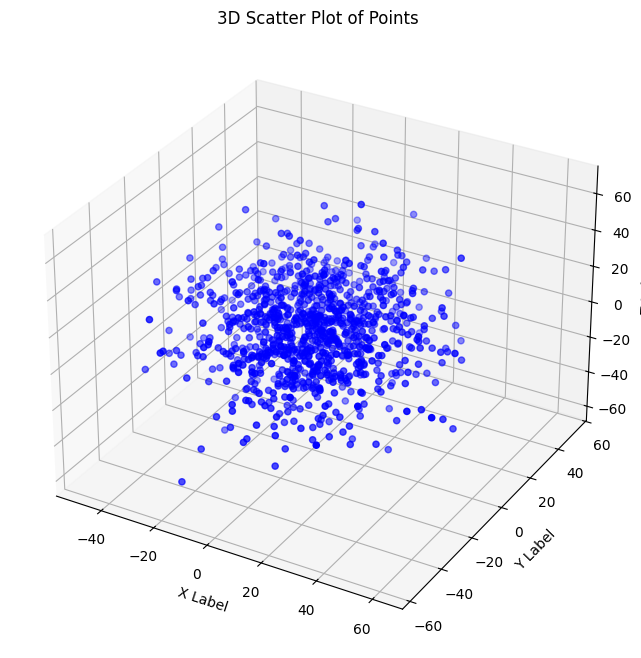

In [90]:
import matplotlib.pyplot as plt
import numpy as np
def sample_sphere(DIM, r, center):
    """Sample a random point on the surface of a sphere."""
    vec = np.random.normal(0, 1, DIM)
    vec = np.sum(vec**2)**0.5
    vec = vec / np.linalg.norm(vec)  # Normalize to lie on the unit sphere
    return np.round(center + r * vec, decimals=1)

# 1. Prepare your data (example: random points)
# Generate 100 random points for x, y, and z
DIM = 3
r = 1000

n = 1000
data = np.array([np.random.normal(0, 1, DIM) for _ in range(n)])
norm = np.sum(data**2)**0.5
data = data / norm  # Normalize to lie on the unit sphere
data = data * r  # Take only the first DIM dimensions
data = data.T  # Transpose to get each dimension as a separate array

# 2. Create a figure and 3D axes
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d') # '111' means 1 row, 1 column, 1st subplot

# 3. Plot the points
ax.scatter(data[0], data[1], data[2], c='b', marker='o') # 'c' for color, 'marker' for point style

# 4. Add labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot of Points')

# 5. Display the plot
plt.show()

$\alpha$ = 2
print($\alpha$)